# CitiBike Accident Prediction

We need to transform the CitiBike and NYPD datasets into a structured format where we can predict the likelihood of a CitiBike accident. Below is a step-by-step breakdown of how we should engineer meaningful features.

# Step 1: Define the Prediction Goal
- We want to predict the probability of an accident for a CitiBike trip.

- Target Variable (accident_risk): Binary (1 = Accident, 0 = No Accident).
- How to define an accident? → If a CitiBike trip starts or ends near an accident location, it's classified as an accident-prone ride.

 
# Step 2: Feature Engineering
We will extract features from both datasets to enrich CitiBike trip records.

## CitiBike Features
Time-Based Features 

- hour_of_day: Extracted from started_at
- day_of_week: Extracted from started_at (0 = Monday, 6 = Sunday)
- weekend: Boolean flag (1 = Weekend, 0 = Weekday)
- season: Winter, Spring, Summer, Fall (Derived from started_at)
- rush_hour: Boolean flag (1 = Peak commuting hours, 0 = Off-peak)
- Trip-Based Features 

- trip_duration: Difference between ended_at and started_at
- trip_distance: Approximate using Haversine formula between start_lat, start_lng and end_lat, end_lng
- member_casual: Encoded (0 = Casual, 1 = Member)
- rideable_type: One-hot encode different bike types (e.g., classic, electric)
- Geographical Features

- start_accident_count: Number of accidents within 100m radius of start_lat, start_lng
- end_accident_count: Number of accidents within 100m radius of end_lat, end_lng
- start_high_risk: Boolean flag (1 = High accident zone, 0 = Safe zone)
- end_high_risk: Boolean flag (1 = High accident zone, 0 = Safe zone)

## NYPD Features
Accident Severity Features 

- cyclist_injured: Number of cyclists injured (NUMBER OF CYCLIST INJURED)
- cyclist_killed: Number of cyclist fatalities (NUMBER OF CYCLIST KILLED)
- total_injuries: Sum of all injuries in the accident (NUMBER OF PERSONS INJURED)
- total_fatalities: Sum of all fatalities in the accident (NUMBER OF PERSONS KILLED)

Location-Based Features 

- borough: Categorical encoding (One-hot encoding)
- zip_code: Categorical encoding (One-hot encoding)
- high_risk_area: Boolean flag (1 = More than X accidents in the region)
- Time-Based Features

- crash_hour: Extracted from CRASH TIME
- crash_weekend: Boolean flag (1 = Weekend, 0 = Weekday)
- crash_rush_hour: Boolean flag (1 = Peak traffic hours)
- Accident Cause Features 🚗

- contributing_factor_vehicle_1: One-hot encoding of CONTRIBUTING FACTOR VEHICLE 1
- contributing_factor_vehicle_2: One-hot encoding of CONTRIBUTING FACTOR VEHICLE 2
- vehicle_type_code_1: One-hot encoding of VEHICLE TYPE CODE 1


# Step 3: Data Merging

We need to merge CitiBike data with NYPD accident data using:

Time proximity: CitiBike started_at should be within X minutes of an accident’s CRASH DATE + CRASH TIME
Location proximity: CitiBike start_lat, start_lng should be within 100m of an accident's LATITUDE, LONGITUDE

How?

Use KDTree for fast geospatial lookups (like before).
Filter by date and time to ensure the accident is relevant.


# Citybike dataset 


In [15]:
import pandas as pd
import numpy as np
from datetime import datetime
from geopy.distance import geodesic

# Load CitiBike data
citibike_df = pd.read_csv("/Users/shashankhmg/Documents/AXA-Casestudy/Data-Science-Challenge/data/processed/cleaned_citibike_data.csv")

# Convert 'started_at' and 'ended_at' to datetime format
citibike_df['started_at'] = pd.to_datetime(citibike_df['started_at'])
citibike_df['ended_at'] = pd.to_datetime(citibike_df['ended_at'])

# Time-Based Features**
citibike_df["hour_of_day"] = citibike_df["started_at"].dt.hour
citibike_df["day_of_week"] = citibike_df["started_at"].dt.dayofweek  # Monday = 0, Sunday = 6
citibike_df["weekend"] = (citibike_df["day_of_week"] >= 5).astype(int)  # 1 = Weekend, 0 = Weekday
# Classify rush hour: 1 = Rush hour, 0 = Non-rush hour
# Rush hour is typically considered:
# - Morning: 7 AM to 9 AM (commuters going to work)
# - Evening: 4 PM to 7 PM (commuters returning home)

citibike_df["rush_hour"] = np.where(
    ((citibike_df["hour_of_day"] >= 7) & (citibike_df["hour_of_day"] <= 9)) | 
    ((citibike_df["hour_of_day"] >= 16) & (citibike_df["hour_of_day"] <= 19)), 
    1,  # Rush Hour
    0   # Non-Rush Hour
)

# Trip-Based Features**
citibike_df["trip_duration"] = (citibike_df["ended_at"] - citibike_df["started_at"]).dt.total_seconds() / 60  # Convert to minutes

# Compute distance using geodesic distance
def compute_distance(row):
    return geodesic((row["start_lat"], row["start_lng"]), (row["end_lat"], row["end_lng"])).km

citibike_df["trip_distance"] = citibike_df.apply(compute_distance, axis=1)

# One-hot encoding categorical features
citibike_df["member_casual"] = citibike_df["member_casual"].map({"member": 1, "casual": 0})  # Encode membership
# Convert 'rideable_type' into a single binary column (1 = electric, 0 = classic)
citibike_df["rideable_type"] = citibike_df["rideable_type"].map({"electric_bike": 1, "classic_bike": 0})

# Geographical Features**
citibike_df["start_coordinates"] = list(zip(citibike_df["start_lat"], citibike_df["start_lng"]))
citibike_df["end_coordinates"] = list(zip(citibike_df["end_lat"], citibike_df["end_lng"]))

# the dataset I have selected is citybike 01.2025 and hence everything is in wintr. so it makes sense not introducing the column, but we must consider if we use the complete dataset

# Drop unnecessary columns
citibike_features = citibike_df.drop(columns=["ride_id", "started_at", "ended_at", 
                                              "start_station_name", "end_station_name", 
                                              "start_station_id", "end_station_id" ])

/var/folders/tw/yc01l_99601d14ks8nxwg1dr0000gn/T/ipykernel_93260/1053066854.py:7: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  citibike_df = pd.read_csv("/Users/shashankhmg/Documents/AXA-Casestudy/Data-Science-Challenge/data/processed/cleaned_citibike_data.csv")


In [16]:
citibike_features.columns

Index(['rideable_type', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'hour_of_day', 'day_of_week', 'weekend', 'rush_hour',
       'trip_duration', 'trip_distance', 'start_coordinates',
       'end_coordinates'],
      dtype='object')

In [17]:
citibike_features

,rideable_type,start_lat,start_lng,end_lat,end_lng,member_casual,hour_of_day,day_of_week,weekend,rush_hour,trip_duration,trip_distance,start_coordinates,end_coordinates
0,1,40.752149,-73.989539,40.744876,-73.995299,1,22,2,0,0,4.442917,0.942805,"(40.752149, -73.989539)","(40.74487634, -73.99529885)"
1,1,40.738290,-73.990060,40.744876,-73.995299,1,15,3,0,0,5.585767,0.854840,"(40.73829, -73.99006)","(40.74487634, -73.99529885)"
2,1,40.745248,-73.947333,40.763359,-73.928647,1,12,2,0,0,8.616567,2.556361,"(40.74524768, -73.94733276)","(40.7633589, -73.9286471)"
3,1,40.738290,-73.990060,40.744876,-73.995299,1,13,1,0,0,5.089867,0.854840,"(40.73829, -73.99006)","(40.74487634, -73.99529885)"
4,1,40.812299,-73.920370,40.792327,-73.938300,1,7,0,0,1,8.680650,2.684817,"(40.812299, -73.92037)","(40.7923272, -73.9383)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119676,0,40.759604,-73.927144,40.761149,-73.917007,1,14,4,0,0,6.917867,0.872972,"(40.759604471387945, -73.92714411020279)","(40.7611488, -73.9170071)"
2119677,1,40.712628,-73.960575,40.719156,-73.948854,1,20,2,0,0,4.015833,1.227322,"(40.712628, -73.960575)","(40.71915571696044, -73.94885390996933)"
2119678,1,40.735324,-73.998004,40.733424,-74.008515,0,15,1,0,0,2.683867,0.912599,"(40.73532427, -73.99800419)","(40.73342399437081, -74.00851495563984)"
2119679,1,40.794990,-73.933330,40.773914,-73.954395,1,9,6,1,1,10.173150,2.939312,"(40.79499, -73.93333)","(40.77391390238118, -73.9543953537941)"


In [18]:
# Save cleaned CitiBike dataset
citibike_features.to_csv("/Users/shashankhmg/Documents/AXA-Casestudy/Data-Science-Challenge/data/model_data/citibike_features.csv", index=False)


# NYPD Dataset


In [20]:
import pandas as pd
import numpy as np

# Load NYPD accident data
nypd_df = pd.read_csv("/Users/shashankhmg/Documents/AXA-Casestudy/Data-Science-Challenge/data/processed/nypd_data_cleaned.csv")  # Replace with actual path

# Convert 'CRASH DATE' and 'CRASH TIME' to datetime format
nypd_df["CRASH_DATETIME"] = pd.to_datetime(nypd_df["CRASH DATE"] + " " + nypd_df["CRASH TIME"])

# 1️⃣ **Time-Based Features**
nypd_df["hour_of_day"] = nypd_df["CRASH_DATETIME"].dt.hour
nypd_df["day_of_week"] = nypd_df["CRASH_DATETIME"].dt.dayofweek  # Monday = 0, Sunday = 6
nypd_df["weekend"] = (nypd_df["day_of_week"] >= 5).astype(int)  # 1 = Weekend, 0 = Weekday

# Define Rush Hour (Same logic as CitiBike)
nypd_df["rush_hour"] = np.where(
    ((nypd_df["hour_of_day"] >= 7) & (nypd_df["hour_of_day"] <= 9)) | 
    ((nypd_df["hour_of_day"] >= 16) & (nypd_df["hour_of_day"] <= 19)), 
    1,  # Rush Hour
    0   # Non-Rush Hour
)

# Location-Based Features
# Encode borough names into numeric values
nypd_df["borough_encoded"] = pd.factorize(nypd_df["BOROUGH"])[0]  # -1 means missing value
nypd_df["accident_coordinates"] = list(zip(nypd_df["LATITUDE"], nypd_df["LONGITUDE"]))

# 3️Accident Severity Features**
nypd_df["total_injuries"] = (
    nypd_df["NUMBER OF PERSONS INJURED"] + 
    nypd_df["NUMBER OF PEDESTRIANS INJURED"] + 
    nypd_df["NUMBER OF CYCLIST INJURED"] + 
    nypd_df["NUMBER OF MOTORIST INJURED"]
)

nypd_df["total_fatalities"] = (
    nypd_df["NUMBER OF PERSONS KILLED"] + 
    nypd_df["NUMBER OF PEDESTRIANS KILLED"] + 
    nypd_df["NUMBER OF CYCLIST KILLED"] + 
    nypd_df["NUMBER OF MOTORIST KILLED"]
)

nypd_df["cyclist_injuries_ratio"] = np.where(nypd_df["total_injuries"] > 0, 
                                             nypd_df["NUMBER OF CYCLIST INJURED"] / nypd_df["total_injuries"], 
                                             0)

nypd_df["cyclist_fatalities_ratio"] = np.where(nypd_df["total_fatalities"] > 0, 
                                               nypd_df["NUMBER OF CYCLIST KILLED"] / nypd_df["total_fatalities"], 
                                               0)

In [21]:
# Drop unnecessary columns
nypd_features = nypd_df.drop(columns=["CRASH DATE", "CRASH TIME", "CRASH_DATETIME", 
                                      "ZIP CODE", "ON STREET NAME","LOCATION"])

In [24]:
nypd_features.columns

Index(['BOROUGH', 'LATITUDE', 'LONGITUDE', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'COLLISION_ID', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'hour_of_day', 'day_of_week', 'weekend',
       'rush_hour', 'borough_encoded', 'accident_coordinates',
       'total_injuries', 'total_fatalities', 'cyclist_injuries_ratio',
       'cyclist_fatalities_ratio'],
      dtype='object')

In [23]:
# Save cleaned nypd_features dataset
nypd_features.to_csv("/Users/shashankhmg/Documents/AXA-Casestudy/Data-Science-Challenge/data/model_data/nypd_features.csv", index=False)


# Step 1: Train the NYPD Accident Prediction Model
We'll create a model that predicts accident risk based on location, time, and accident history.

## Preprocessing the NYPD Data
Convert date & time to datetime.
Extract hour, day of the week, and weekend flag.
Categorize accidents into "High-Risk", "Medium-Risk", and "Low-Risk" zones.
Use spatial clustering (DBSCAN) to group high-risk accident locations.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Load preprocessed NYPD accident data
nypd_accidents = nypd_features.copy()

# Selecting relevant features
features = [
    "LATITUDE", "LONGITUDE", "hour_of_day", "day_of_week", "weekend", "rush_hour",
    "borough_encoded", "total_injuries", "total_fatalities",
    "cyclist_injuries_ratio", "cyclist_fatalities_ratio"
]

target = "accident_severity"  # Define accident severity as the target

# Define severity as binary classification (1 = High-Risk, 0 = Low-Risk) if total injury > 0
nypd_accidents["accident_severity"] = np.where(nypd_accidents["total_injuries"] > 0, 1, 0)

# Drop NaN values for modeling
nypd_accidents = nypd_accidents.dropna(subset=features)


In [28]:
# Standardize numerical features for better model performance (normalization)
scaler = StandardScaler()
nypd_accidents[features] = scaler.fit_transform(nypd_accidents[features])



In [29]:
nypd_accidents[features]

,LATITUDE,LONGITUDE,hour_of_day,day_of_week,weekend,rush_hour,borough_encoded,total_injuries,total_fatalities,cyclist_injuries_ratio,cyclist_fatalities_ratio
0,-1.301753,-0.619143,-2.152210,-0.471371,-0.585638,-0.804348,-1.207403,1.035105,-0.034374,-0.179498,-0.011039
1,-0.716753,0.667031,-0.748623,1.067128,1.707538,1.243242,-1.207403,-0.446849,-0.034374,-0.179498,-0.011039
2,-0.509327,0.036219,-0.924072,-0.984204,-0.585638,1.243242,-1.207403,-0.446849,-0.034374,-0.179498,-0.011039
3,1.871996,1.102116,-0.924072,-0.984204,-0.585638,1.243242,-0.432286,2.517059,-0.034374,-0.179498,-0.011039
4,-0.658552,0.286859,1.356756,-0.984204,-0.585638,-0.804348,-1.207403,-0.446849,-0.034374,-0.179498,-0.011039
...,...,...,...,...,...,...,...,...,...,...,...
1437812,-0.129100,0.203991,-2.327658,0.041462,-0.585638,-0.804348,1.117950,-0.446849,-0.034374,-0.179498,-0.011039
1437813,1.331491,1.223871,-0.573175,0.554295,-0.585638,-0.804348,-0.432286,1.035105,-0.034374,-0.179498,-0.011039
1437814,0.547980,0.108824,-2.327658,-0.471371,-0.585638,-0.804348,1.117950,-0.446849,-0.034374,-0.179498,-0.011039
1437815,0.547941,0.386871,-0.924072,0.554295,-0.585638,1.243242,1.117950,1.035105,-0.034374,-0.179498,-0.011039


In [32]:
nypd_accidents[target]

0          1
1          0
2          0
3          1
4          0
          ..
1437812    0
1437813    1
1437814    0
1437815    1
1437816    0
Name: accident_severity, Length: 1437817, dtype: int64

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    nypd_accidents[features], nypd_accidents[target], test_size=0.2, random_state=42
)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

In [31]:
# Predict & evaluate
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    221156
           1       1.00      1.00      1.00     66408

    accuracy                           1.00    287564
   macro avg       1.00      1.00      1.00    287564
weighted avg       1.00      1.00      1.00    287564



In [ ]:
# DBSCAN is a clustering algorithm that groups points based on density (how close they are to each other). 
# It helps us identify accident hotspots where many CitiBike accidents occur.

#eps=0.002 → Defines the maximum distance (in degrees) between two points to be considered in the same cluster (~200m).
#min_samples=10 → Defines minimum number of points required to form a cluster (at least 10 accidents must be nearby to create a hotspot).
#fit_predict() → Assigns a cluster label to each accident location. If a point doesn't belong to a cluster, it's labeled as -1 (noise).


In [33]:
# Assign risk scores to accident locations using DBSCAN clustering
dbscan = DBSCAN(eps=0.002, min_samples=10)  # Identifying accident hotspots
nypd_accidents["risk_cluster"] = dbscan.fit_predict(nypd_accidents[["LATITUDE", "LONGITUDE"]])

In [34]:
# This assigns a cluster label (risk_cluster) to each accident in the dataset.
# Accidents that belong to the same cluster are part of the same accident hotspot.
# Accidents not part of any cluster are labeled as -1 (noise/outliers).



In [44]:
nypd_accidents["risk_cluster"].value_counts()

risk_cluster
-1        235457
 1007       1203
 16          956
 1188        867
 5318        853
           ...  
 24830         4
 27797         4
 27264         3
 27652         3
 27795         3
Name: count, Length: 27879, dtype: int64

/var/folders/tw/yc01l_99601d14ks8nxwg1dr0000gn/T/ipykernel_93260/813608291.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_summary["risk_cluster"].astype(str), y=risk_summary["total_injuries"], palette="Reds")


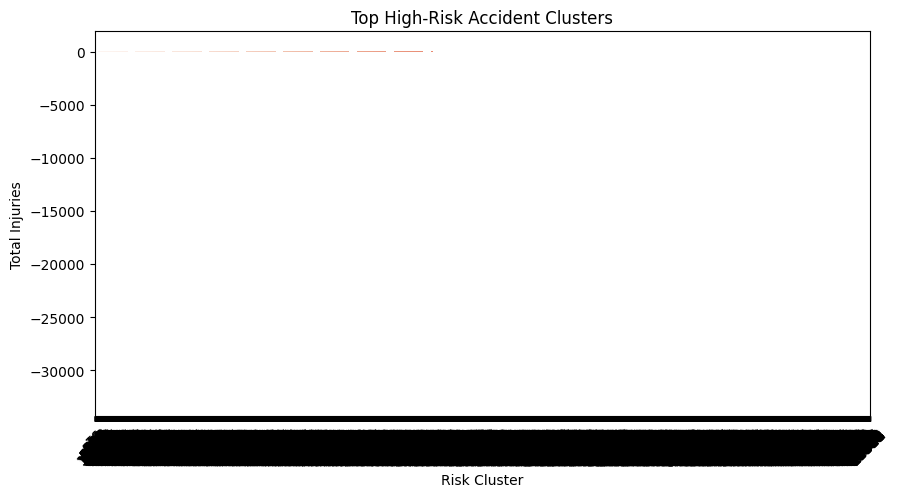

In [35]:
# Aggregate accidents by risk cluster
risk_summary = nypd_accidents.groupby("risk_cluster")["total_injuries"].sum().reset_index()
risk_summary = risk_summary.sort_values(by="total_injuries", ascending=False)

# Visualizing Top Risk Clusters
plt.figure(figsize=(10, 5))
sns.barplot(x=risk_summary["risk_cluster"].astype(str), y=risk_summary["total_injuries"], palette="Reds")
plt.xlabel("Risk Cluster")
plt.ylabel("Total Injuries")
plt.title("Top High-Risk Accident Clusters")
plt.xticks(rotation=45)
plt.show()


# Step 2: Assign Risk Scores to CitiBike Stations


In [37]:
from scipy.spatial import cKDTree

# Convert CitiBike station coordinates to numpy array
station_coords = np.array(list(zip(citibike_features["start_lat"], citibike_features["start_lng"])))

# Use KDTree for fast spatial lookup
accident_tree = cKDTree(nypd_accidents[["LATITUDE", "LONGITUDE"]].values)

# Define search radius (100m = ~0.001 degrees)
search_radius = 0.001

# Count accidents near each CitiBike station
accident_counts = accident_tree.query_ball_point(station_coords, search_radius)

# Assign risk scores to stations
citibike_features["risk_score"] = [len(accidents) for accidents in accident_counts]

In [41]:
citibike_features["risk_score"].value_counts()

risk_score
0    2119681
Name: count, dtype: int64

In [ ]:
# Normalize risk scores (0 to 1)
citibike_stations["risk_score"] = citibike_stations["risk_score"] / citibike_stations["risk_score"].max()

# Merge risk scores with CitiBike dataset
citibike_df = citibike_df.merge(
    citibike_stations[["start_station_name", "risk_score"]],
    on="start_station_name",
    how="left"
)
